# YOLOv2

## Prepare Data
### Preparing Pascal VOC 2007
To Prepare the data first go to Examples/Images/DataSets/Pascal and install the data with the install_data.py scripts. 
Then go to Examples/Images/DataSets/Pascal/mappings and run create_mappings.py to preprocess the ground truth boxes.

## Train the model

In [1]:
import os, sys
import Distributed_YOLOv2 as dy
import PARAMETERS as par
import YOLOv2 as yolo2
from ErrorFunction import get_error
from cntk import input_variable, Communicator


In [2]:
model = yolo2.create_yolov2_net(par)
image_input = input_variable((par.par_num_channels, par.par_image_height, par.par_image_width), name="data")
output = model(image_input)  # append model to image input

# input for ground truth boxes
num_gtb = par.par_max_gtbs
gtb_input = input_variable((num_gtb * 5))  # 5 for class, x,y,w,h

if not par.par_boxes_centered:
    original_shape = gtb_input.shape
    new_shape = (num_gtb, 5)
    reshaped = reshape(gtb_input, new_shape)
    xy = reshaped[:,0:2]
    wh = reshaped[:,2:4]
    cls = reshaped[:,4:]
    center_xy = xy + wh*.5
    new_gtb = splice(xy,wh,cls,axis=1)
    gtb_transformed = reshape(new_gtb, gtb_input.shape)
else:
    gtb_transformed = gtb_input

mse = get_error(output, gtb_transformed, cntk_only=False)# + zero

network = {
    'feature': image_input,
    'gtb_in': gtb_input,
    'mse': mse,
    'output': output
}



#from cntk.logging.graph import plot
#plot(output, "./yopar.png")
#plot(network['mse'], "./yolo_mse.png")



In [3]:
data_path = os.path.join(par.par_abs_path, "..", "..", "DataSets","Pascal", "mappings")

train_image_file = os.path.join(data_path, par.par_train_data_file)
train_gt_file = os.path.join(data_path, par.par_train_roi_file)

test_image_file =None # os.path.join(data_path, par.par_test_data_file)
test_gt_file =None # os.path.join(data_path, par.par_test_roi_file)

log_dir = None

In [4]:
base_lr = 1e-3
#par.par_lr_schedule = [base_lr * 0.1]*10 + [base_lr * 1]*30
par.par_lr_schedule = [base_lr]*45 + [base_lr * 0.1]*30 + [base_lr * 0.01]
par.par_max_epochs = 160
par.par_minibatch_size = 128

In [ ]:
from cntk.cntk_py import force_deterministic_algorithms_deterministic_algorithms_deterministic_algorithms_deterministic_algorithms
force_deterministic_algorithms()

In [5]:
#training!
try:
    output = dy.yolov2_train_and_eval(network, 
                                   train_image_file, train_gt_file,
                                   test_image_file, test_gt_file,
                                   max_epochs=par.par_max_epochs,
                                   log_to_file=log_dir,
                                   num_mbs_per_log=50,
                                   minibatch_size=par.par_minibatch_size,
                                   epoch_size=par.par_epoch_size,
                                   gen_heartbeat=False)

finally:
    Communicator.finalize()
    print("Training finished!")

Finished Epoch[1 of 160]: [Training] loss = 17.615755 * 5120, metric = 1761.58% * 5120 101.698s ( 50.3 samples/s);
Finished Epoch[2 of 160]: [Training] loss = 5.282351 * 4992, metric = 528.24% * 4992 56.844s ( 87.8 samples/s);
Finished Epoch[3 of 160]: [Training] loss = 4.983249 * 4992, metric = 498.32% * 4992 56.652s ( 88.1 samples/s);
Finished Epoch[4 of 160]: [Training] loss = 4.803169 * 4992, metric = 480.32% * 4992 56.619s ( 88.2 samples/s);
Finished Epoch[5 of 160]: [Training] loss = 4.710456 * 4992, metric = 471.05% * 4992 56.233s ( 88.8 samples/s);
Finished Epoch[6 of 160]: [Training] loss = 4.638523 * 4992, metric = 463.85% * 4992 56.768s ( 87.9 samples/s);
Finished Epoch[7 of 160]: [Training] loss = 4.607803 * 5120, metric = 460.78% * 5120 58.939s ( 86.9 samples/s);
Finished Epoch[8 of 160]: [Training] loss = 4.636218 * 4992, metric = 463.62% * 4992 55.040s ( 90.7 samples/s);
Finished Epoch[9 of 160]: [Training] loss = 4.646954 * 4992, metric = 464.70% * 4992 56.380s ( 88.5 s

Finished Epoch[74 of 160]: [Training] loss = 6.142403 * 4992, metric = 614.24% * 4992 55.896s ( 89.3 samples/s);
Finished Epoch[75 of 160]: [Training] loss = 6.200084 * 5120, metric = 620.01% * 5120 57.485s ( 89.1 samples/s);
Finished Epoch[76 of 160]: [Training] loss = 6.246180 * 4992, metric = 624.62% * 4992 56.410s ( 88.5 samples/s);
Finished Epoch[77 of 160]: [Training] loss = 6.227872 * 4992, metric = 622.79% * 4992 55.761s ( 89.5 samples/s);
Finished Epoch[78 of 160]: [Training] loss = 6.203496 * 4992, metric = 620.35% * 4992 56.545s ( 88.3 samples/s);
Finished Epoch[79 of 160]: [Training] loss = 6.178968 * 4992, metric = 617.90% * 4992 55.757s ( 89.5 samples/s);
Finished Epoch[80 of 160]: [Training] loss = 6.200811 * 4992, metric = 620.08% * 4992 55.947s ( 89.2 samples/s);
Finished Epoch[81 of 160]: [Training] loss = 6.146067 * 5120, metric = 614.61% * 5120 57.216s ( 89.5 samples/s);
Finished Epoch[82 of 160]: [Training] loss = 6.242652 * 4992, metric = 624.27% * 4992 56.306s ( 

Finished Epoch[147 of 160]: [Training] loss = 5.833161 * 4992, metric = 583.32% * 4992 56.145s ( 88.9 samples/s);
Finished Epoch[148 of 160]: [Training] loss = 5.805922 * 4992, metric = 580.59% * 4992 55.782s ( 89.5 samples/s);
Finished Epoch[149 of 160]: [Training] loss = 5.826650 * 5120, metric = 582.67% * 5120 57.580s ( 88.9 samples/s);
Finished Epoch[150 of 160]: [Training] loss = 5.827721 * 4992, metric = 582.77% * 4992 55.855s ( 89.4 samples/s);
Finished Epoch[151 of 160]: [Training] loss = 5.794943 * 4992, metric = 579.49% * 4992 56.023s ( 89.1 samples/s);
Finished Epoch[152 of 160]: [Training] loss = 5.821545 * 4992, metric = 582.15% * 4992 56.155s ( 88.9 samples/s);
Finished Epoch[153 of 160]: [Training] loss = 5.783371 * 4992, metric = 578.34% * 4992 55.943s ( 89.2 samples/s);
Finished Epoch[154 of 160]: [Training] loss = 5.796595 * 4992, metric = 579.66% * 4992 55.988s ( 89.2 samples/s);
Finished Epoch[155 of 160]: [Training] loss = 5.761844 * 5120, metric = 576.18% * 5120 5

In [6]:
output_dir = "."
if output is not None and output_dir is not None:
    save_path = os.path.join(output_dir, "YOLOv2.model")
    output.save(save_path)
    print("Saved model to " + save_path)
trained_model = output

Saved model to .\YOLOv2.model


In [7]:
from cntk import load_model
trained_model = load_model(os.path.join(".", "YOLOv2.model"))

## Evaluate

Box out of bounds: (201,111) (501,267)
Box out of bounds: (218,125) (307,288)


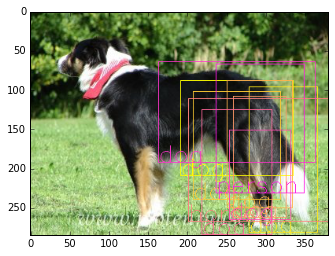

Box out of bounds: (-59,149) (521,293)
Box out of bounds: (-129,67) (591,300)
Box out of bounds: (151,167) (233,407)
Box out of bounds: (-169,157) (708,273)


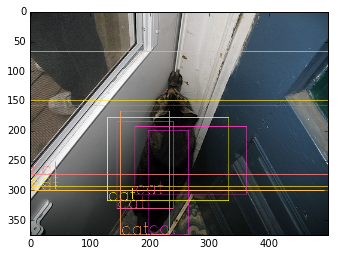

Box out of bounds: (11,1) (142,337)
Box out of bounds: (115,145) (422,382)
Box out of bounds: (16,106) (137,334)
Box out of bounds: (81,124) (226,367)
Box out of bounds: (53,127) (177,365)
Box out of bounds: (-22,123) (252,404)
Box out of bounds: (-77,96) (231,283)


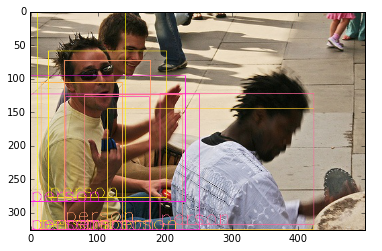

Box out of bounds: (100,-162) (347,357)
Box out of bounds: (78,43) (521,235)
Box out of bounds: (219,-30) (303,376)


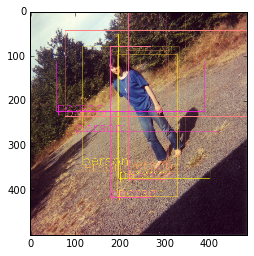

Box out of bounds: (26,27) (666,323)
Box out of bounds: (246,33) (523,317)


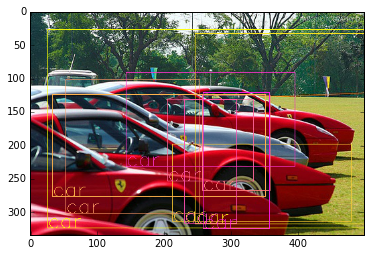

Box out of bounds: (-37,31) (268,356)
Box out of bounds: (80,140) (612,233)
Box out of bounds: (-50,108) (204,334)
Box out of bounds: (-12,217) (781,262)
Box out of bounds: (54,-10) (380,585)
Box out of bounds: (138,-10) (405,595)
Box out of bounds: (12,76) (367,413)
Box out of bounds: (16,-135) (417,640)
Box out of bounds: (12,-57) (312,412)
Box out of bounds: (93,146) (396,505)
Box out of bounds: (-50,65) (376,489)
Box out of bounds: (111,-128) (268,492)
Box out of bounds: (166,135) (432,451)
Box out of bounds: (222,181) (318,377)
Box out of bounds: (263,168) (353,394)
Box out of bounds: (154,169) (537,318)
Box out of bounds: (-220,243) (682,358)
Box out of bounds: (-171,182) (556,365)
Box out of bounds: (-24,219) (485,328)
Box out of bounds: (-60,231) (599,303)
Box out of bounds: (-248,261) (633,341)
Box out of bounds: (-68,159) (376,391)
Box out of bounds: (-46,157) (431,317)
Box out of bounds: (96,-67) (518,402)
Box out of bounds: (99,116) (593,274)
Box out of bounds: (203,32) (56

In [8]:
%matplotlib inline
import evaluate
import cv2
import numpy as np
from cntk import logging

data_input = logging.graph.find_by_name(trained_model, "data")
img_width = data_input.shape[2]
img_height= data_input.shape[1]


obj_min, obj_max=1, 0
data_path= r"../../DataSets/Pascal/VOCdevkit/VOC2007/JPEGImages"
img_list = [18,118,1118,27,2118,4118,1,2,3,4,5,6,7,8,9,10]
# img_list = open(r"..\..\DataSets\Pascal\VOCdevkit\VOC2007\ImageSets\Main\test.txt").read().split()
save_path = os.path.join(".", "outputdir", "results", "pvoc2007")
if not os.path.exists(save_path):
    results_dir = os.path.join(".", "outputdir", "results")
    if not os.path.exists(results_dir):
        output_dir = os.path.join(".", "outputdir")
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        os.mkdir(results_dir)
    os.mkdir(save_path)

for i in range(len(img_list)):
    img_name =  "{:06}.jpg".format(img_list[i])
    img = evaluate.load_image(os.path.join(data_path, img_name))

    preds = evaluate.predictions_for_image(img, trained_model, img_width, img_height)
    preds_nms = evaluate.do_nms(preds)
    #import ipdb;ipdb.set_trace()
    color_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    evaluate.draw_bb_on_image(color_image, preds_nms)

    if i<5:
        evaluate.plot_image(color_image)

    out_img = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

    evaluate.save_image(out_img, save_path, "bb_"+img_name)

    #import math
    objectnesses = preds[:,4]
    obj_min = np.minimum(obj_min, np.minimum.reduce(objectnesses))
    obj_max = np.maximum(obj_max, np.maximum.reduce(objectnesses))
print((obj_min,obj_max))
